In [1]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 
import theano
from theano import shared, tensor as tt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
plt.style.use('classic')




In [2]:
# Data
cwd = os.chdir("/Users/ArgonLab/Documents")
df1 = pd.read_csv("Kula_Mix_Mica.csv", engine = "python")

In [3]:
df1.head()

,temp1,time1,ar391,ar401,age1,age_err1,temp2,time2,ar392,ar402,age2,age_err2,temp3,time3,ar393,ar403,age3,age_err3
0,725,12,92.06,6137.52,121.86,0.75,725,12,104.06,6223.25,108.19,0.66,725.0,12.0,109.82,5575.05,90.79,0.63
1,775,12,74.49,3128.33,131.81,0.61,775,12,101.34,3596.88,112.79,0.50,775.0,12.0,98.11,2988.19,92.66,0.52
2,820,12,185.53,7118.49,129.69,0.58,820,12,199.84,6747.15,111.24,0.49,820.0,12.0,212.02,6018.54,91.57,0.50
3,850,12,327.39,11860.89,127.00,0.57,840,12,222.71,6878.87,107.21,0.46,850.0,12.0,340.72,8783.32,90.59,0.49
4,875,12,487.57,18061.60,131.10,0.58,860,12,326.00,10333.14,111.16,0.48,875.0,12.0,493.39,13065.36,94.46,0.51


In [4]:
temp1 = df1['temp3'].values
time1 = df1['time3'].values
a391 = df1['ar393'].values
a401 = df1['ar403'].values
age1 = df1['age3'].values
age1_err = df1['age_err3'].values

In [5]:
temp1 = temp1[~np.isnan(temp1)]
time1 = time1[~np.isnan(time1)]
a391 = a391[~np.isnan(a391)]
a401 = a401[~np.isnan(a401)]
age1 = age1[~np.isnan(age1)]
age1_err = age1_err[~np.isnan(age1_err)]

In [6]:
# Shared variable for modelling 

data = age1
err = age1_err

age_err = shared(err*2)

In [7]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [8]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [9]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [10]:
x = 100 *frel_data(a391)

# The Age Spectra and Fractional Release Curves

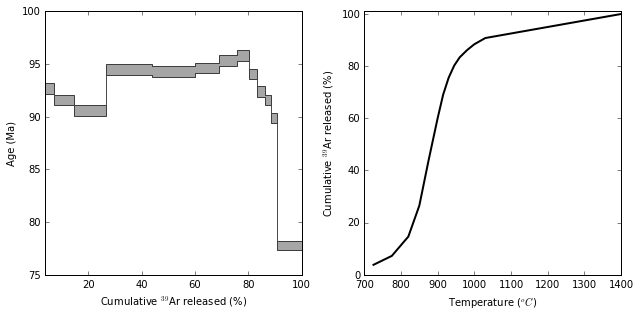

In [11]:
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(x, data - err, data + err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(x.min(), x.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [37]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3

In [38]:
BAr = pm.Model() 
import pymc3.distributions.transforms as tr
with BAr:  
    # Volume Fraction 
    phi = pm.Dirichlet('phi', a = np.array([0.25, 0.75]), 
                      shape = 2, 
                      testval = (0.25, 0.75))
    phi_c = pm.Potential('phi_c', 
                        tt.switch(phi[0] < 0.2, 
                                 -np.inf, 0) + 
                        tt.switch(phi[0] > 0.3, 
                                 -np.inf, 0
                                 ))

    # Diffusion Kinetics 
    # Mineral 
    ea1 = pm.Normal('ea1', mu = 260, sd = 5)
    ea2 = pm.Normal('ea2', mu = 260, sd = 5)
    
    
    
    d01 = pm.Lognormal('d01', -2, 2)
    
    d02 = pm.Lognormal('d02', -2, 2)

    
    a1 = pm.Uniform('a1', lower = 0.0025, upper = 0.0125)
    
    a2 = pm.Uniform('a2', lower = 0.0025, upper = 0.0125)
    

In [39]:
with BAr: 
  # Deterministic
    # Cumulative Release 
    c1 = fracrelx(ea1,d01, a1, tempk, t_obs)

    c2 = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    m1 = phi[0]
    
    m2 = phi[1]
    
    # Cumulative Release Model 
    
    model1 = m1*c1 + m2*c2
    
#Monotonicity
    
####################################################################################################
    for i in range(len(tempk) - 1): 
        Frel_bound_a = pm.Potential(f'f_bound_a{i}', 
                                 tt.switch(c1[i +1] - c1[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_b = pm.Potential(f'f_bound_b{i}', 
                                 tt.switch(c2[i +1] - c2[i] < 0, 
                                          -np.inf, 0)) 

        
        
    for i in range(len(data) - 1): 
        f_con_mu = pm.Potential(f'f_bound_mu{i}', 
                               tt.switch(model1[i + 1] - model1[i] < 0, 
                                        -np.inf, 0))  
########################################################################################################
     
    

In [40]:
with BAr: 
    # Incremental Curves 
    
    i1 = Increment(ea1, d01, a1, tempk, t_obs)
    i2 = Increment(ea2, d02, a2, tempk, t_obs)
    
    
    mu1 = (m1*i1)/(m1*i1 + m2*i2)
    
    mu2 = (m2*i2)/(m1*i1 + m2*i2)
    
    # Deterministic Variables 
    
    mu1_trace = pm.Deterministic('mu1_trace', mu1)
    mu2_trace = pm.Deterministic('mu2_trace', mu2)

 

In [41]:
with BAr: 

    # Ages 
    age1 = pm.Uniform('age1', lower = 0.0, upper = 4600, 
                     testval = 200)
    age2 = pm.Uniform('age2', lower = 0.0, upper = 4600, 
                     testval = 100)
    
    age_cons = pm.Potential('age_cons', 
                           tt.switch(age1 - age2 < 0, 
                                    -np.inf, 0))

In [42]:
with BAr: 
    # Age Spectra Model 
    
    model2 = (mu1*age1) + (mu2*age2)

In [43]:
def logp(mod, data, err): 
    logp = -tt.sqr(data - mod)/(2 * err * err)
    return logp.sum()

In [44]:
with BAr: 
    # Cumulative Release Error 
    f_err = pm.HalfNormal('f_err', sd = 0.1, 
                         shape = N)
    
    # Age Error 
    age_err_model = pm.HalfNormal('age_err_model', 
                                 sd =5,
                                 shape = N)
   

In [45]:
# Models for plotting 

with BAr: 
    f_model = pm.Deterministic('f_model', 
                               model1)
    age_model = pm.Deterministic('Age_Model', 
                                model2)

In [46]:
with BAr: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = model1, sd = f_err, 
                observed = data_f)
    

In [47]:
with BAr: 
    # Age Spectra Likelihood 

    L2 = pm.Normal('L2', mu = model2, 
                   sd = age_err_model, 
                   observed = data)
                   

In [48]:
BAr.check_test_point()

phi_stickbreaking__     -2.05
ea1                     -2.53
ea2                     -2.53
d01_log__               -1.61
d02_log__               -1.61
a1_interval__           -1.39
a2_interval__           -1.39
age1_interval__         -3.18
age2_interval__         -3.85
f_err_log__            -10.78
age_err_model_log__    -10.78
L1                    -418.11
L2                    -523.86
Name: Log-probability of test_point, dtype: float64

In [49]:
SAMPLES = 50000
BURN = 50000


with BAr: 

    trace = pm.sample(SAMPLES, tune = BURN, 
                      step = pm.Metropolis(), 
                     cores = 3)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [age_err_model]
>Metropolis: [f_err]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 3 chains: 100%|██████████| 300000/300000 [14:58<00:00, 333.72draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Traceplot

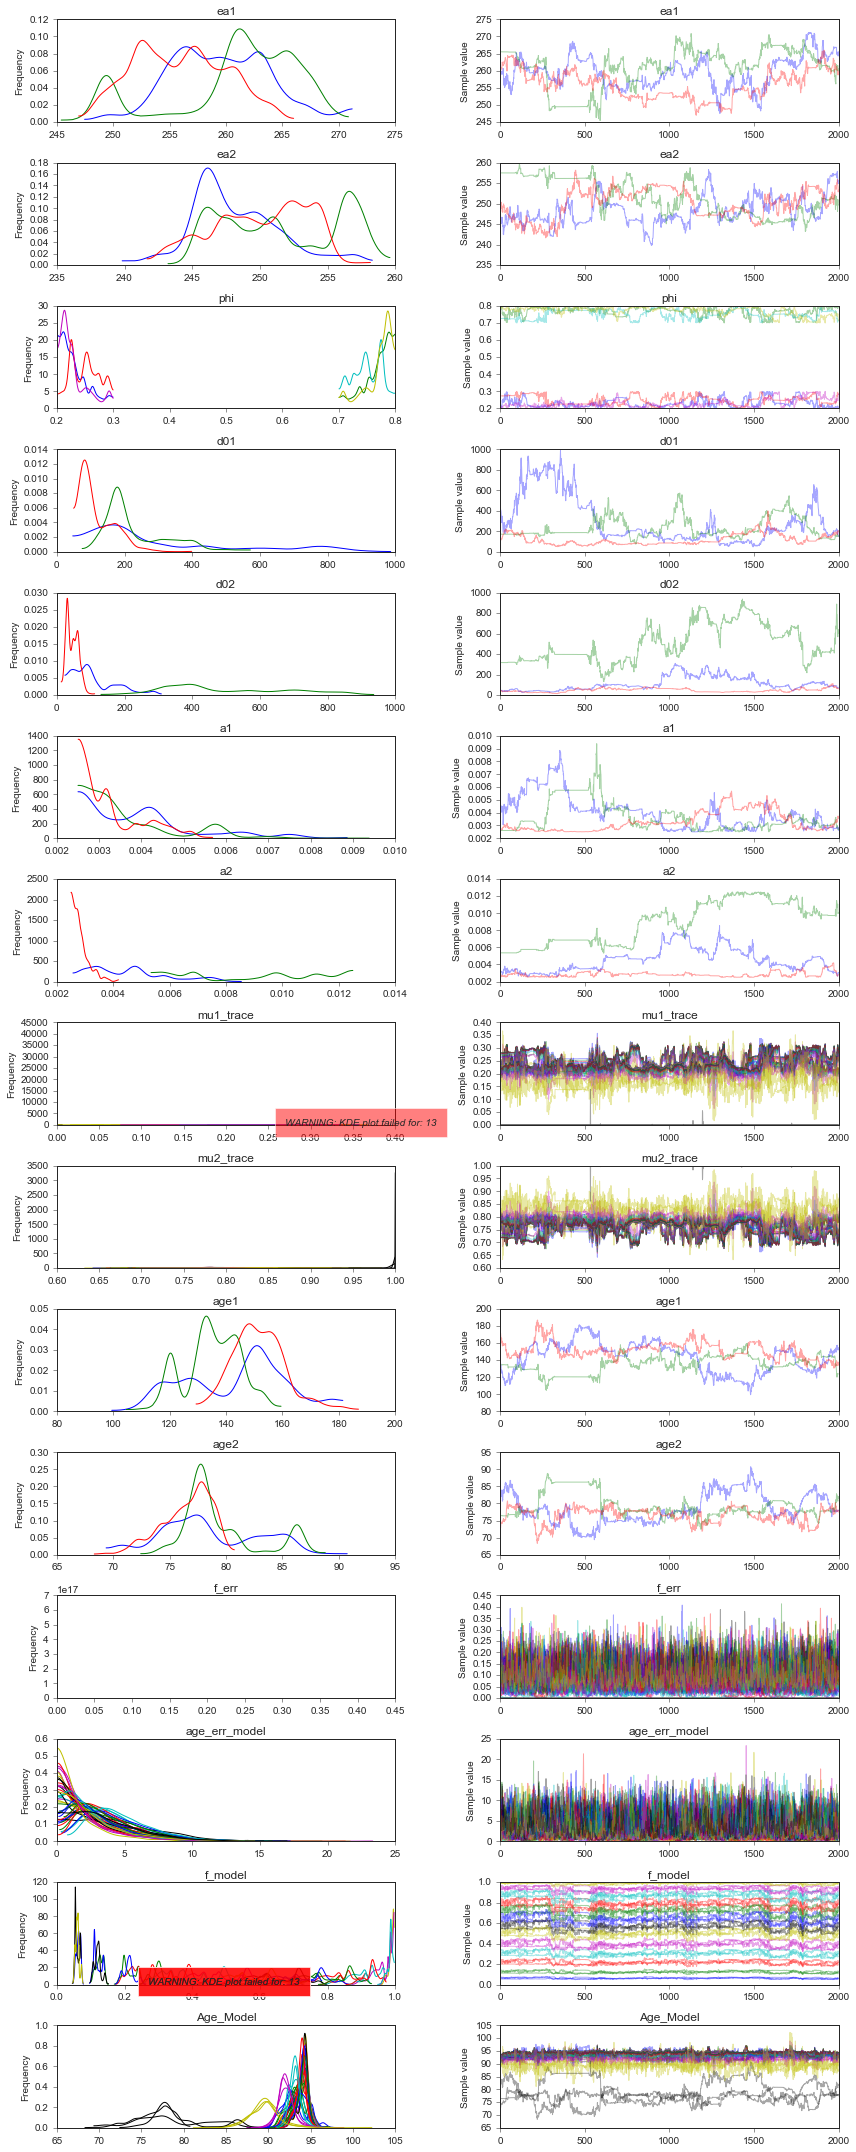

In [50]:
sns.set_style('ticks')
pm.traceplot(trace[-10000::5]); 

##### Plot the Mixing Fractions

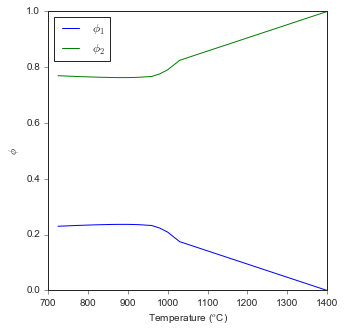

In [51]:
plt.figure(figsize = (5,5))
plt.plot(temp1,trace['mu1_trace'][-10000:].mean(axis = 0), 
        label = '$\phi_{1}$')
plt.plot(temp1, trace['mu2_trace'][-10000:].mean(axis = 0), 
        label = '$\phi_{2}$')
plt.xlabel('Temperature ($^{o}$C)')
plt.ylabel('$\phi$')
plt.legend(loc = 'best')

# 95% Credible Interval 

In [52]:
low1, high1 = np.percentile(trace['f_model'][-1000:], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(trace['Age_Model'][-1000:], [2.5, 97.5], axis = 0)

# Mean Predictive Models
* Plot these to check the mean posterior and the deviation from data

In [53]:
Z1 = trace['f_model'][-1000:].mean(axis = 0)
Z2 = trace['Age_Model'][-1000:].mean(axis = 0)

# Fractional release plot

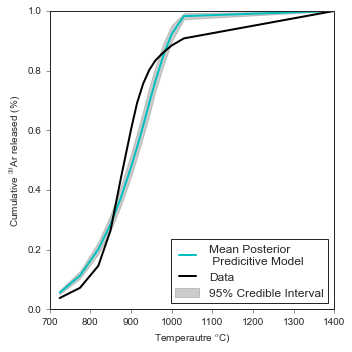

In [54]:
plt.figure(figsize = (5,5))
plt.fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.tight_layout()

# Age Spectra plot

## Combined

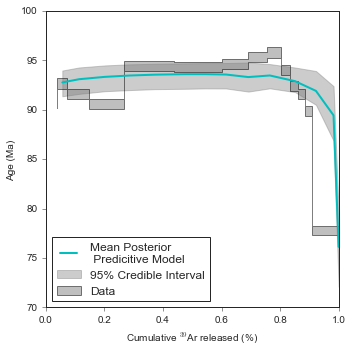

In [55]:
plt.figure(figsize = (5,5))
plt.fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.xlim(0, 1)
plt.tight_layout()

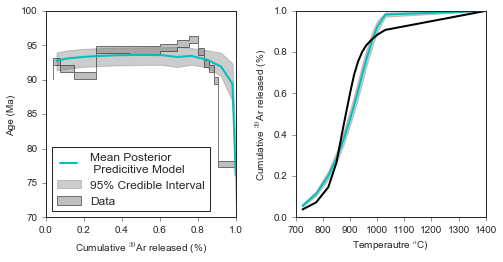

In [56]:
# AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

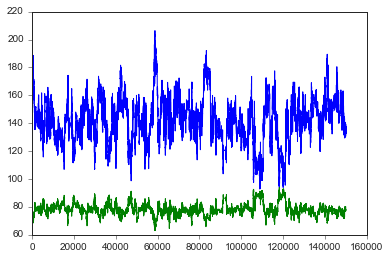

In [57]:
plt.plot(trace['age1'])
plt.plot(trace['age2'])

In [58]:
print(trace['age1'][-50000:].mean(axis = 0))
print(trace['age2'][-50000:].mean(axis = 0))


print(2*np.std(trace['age1'][-50000:]))
print(2*np.std(trace['age2'][-50000:]))

139.30224508334112
78.98433191439894
33.99498008518257
9.6293827591186


# Log Likelihood of each Drawn Sample
* Calculation of logp for each draw in trace
* Cell below

In [59]:
ml = BAr.logp
logp = [ml(i) for i in trace]

Text(0.5, 0, 'Iteration/10')

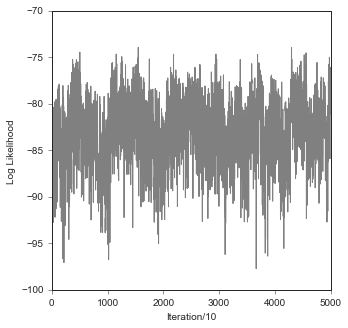

In [60]:
sns.set_style('ticks')
plt.figure(figsize = (5,5))
plt.plot(logp[::10], color = 'grey')
plt.ylabel('Log Likelihood')
plt.xlabel('Iteration/10')

# Log Likelihood and Age trace from paper

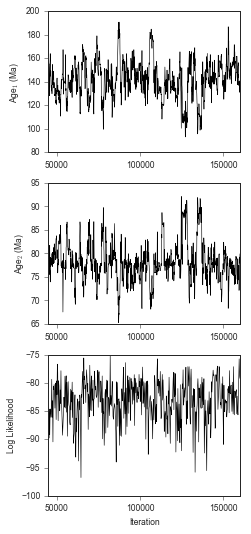

In [61]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8.5}

plt.rc('font', **font)
import seaborn as sns 
fig, ax = plt.subplots(3,1, figsize = (3.54331, 7.48031))
x = np.linspace(40000,159999, len(trace['age1'][-160000::100]))
xz = np.linspace(40000, 160000, len(logp[::100]))
ax[0].plot(x,trace['age1'][-160000::100], 
          color = 'k', lw = 0.6)
ax[1].plot(x,trace['age2'][-160000::100], 
          color = 'k', lw = 0.6)
ax[2].plot(xz,logp[::100], color = 'k', 
          lw= 0.6)

ax[2].set_xlabel('Iteration')


ax[0].set_ylabel('Age$_1$ (Ma)')
ax[1].set_ylabel('Age$_2$ (Ma)')
ax[2].set_ylabel('Log Likelihood')
ax[0].locator_params(axis='x', nbins=5)
ax[1].locator_params(axis='x', nbins=5)
ax[2].locator_params(axis='x', nbins=5)
#labels = ['45000', '47500', '50000']
ax[0].set_xlim(45000, 160000)
ax[1].set_xlim(45000, 160000)
ax[2].set_xlim(45000, 160000)
#ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
#ax[0].set_ylim(18, 30)
#ax[1].set_ylim(0.4, 2)
#ax[2].set_ylim(-750, -650)
plt.savefig('Log_like_trace.pdf')

# Save to DataFrames for plotting

In [62]:
df = pd.DataFrame({"age_model": Z2, 
                  "age_model_low": low2, 
                  "age_model_high": high2, 
                  "frel_model": Z1, 
                  "frel_model_low": low1, 
                  "frel_model_high": high1, 
                   "frel_data": data_f, 
                  "age_data": data, 
                  "age_err": age1_err, 
                  "temp": temp1})

df.to_csv('kula3_muscovite_posterior.csv')

In [63]:
df1 = pm.trace_to_dataframe(trace[-50000::40])
df1.to_csv('kula3_muscovite_trace.csv')

In [64]:
dfp = pd.DataFrame({"age1":df1['age1'].values, 
                   "age2": df1['age2'].values,  
                   "d01":df1['d01'].values, 
                   "d02":df1['d02'].values, 
                   "ea1":df1['ea1'].values, 
                   "ea2":df1['ea2'].values})

Text(0.5, 112.99999999999989, 'E$_a$2 (kjmol$^{-1}$)')

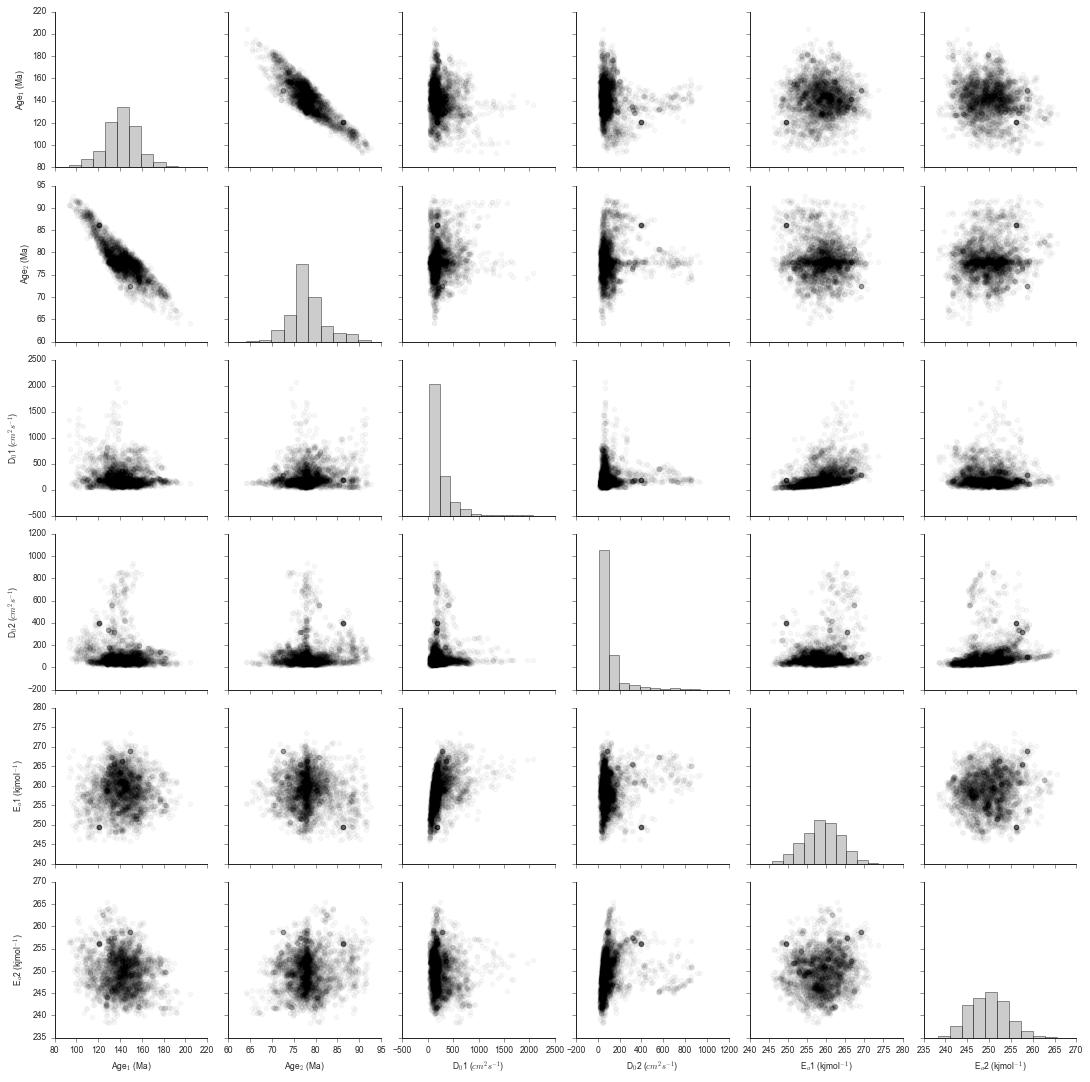

In [66]:
g = sns.PairGrid(dfp[-5000:])
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.4)
g = g.map_offdiag(plt.scatter, alpha = 0.03, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kjmol$^{-1}$)')

In [224]:
dfy = dfp